# 1. Import libraries

In [2]:
!pip -q install "tensorflow>=2.12" matplotlib numpy

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import deque
import random

print("TensorFlow:", tf.__version__)
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)


TensorFlow: 2.19.0


# 2. Environment: Traffic Light RL Simulation

In [3]:
class TrafficLightEnv:
    """
    Simple single-intersection traffic environment.
    Vehicles arrive stochastically, queue up, and pass when green.

    State: [queue_NS, queue_EW, phase]
    Action: 0=keep, 1=switch
    Reward: negative congestion and switching penalty
    """

    def __init__(self,
                 max_steps=300,
                 arrival_ns=0.8,   # avg cars per step (Poisson rate)
                 arrival_ew=0.8,
                 service_rate=2,   # cars that can pass per green step
                 switch_penalty=2, # discourage too-frequent switching
                 max_queue=50):
        self.max_steps = max_steps
        self.arrival_ns = arrival_ns
        self.arrival_ew = arrival_ew
        self.service_rate = service_rate
        self.switch_penalty = switch_penalty
        self.max_queue = max_queue
        self.reset()

    def reset(self):
        self.t = 0
        self.queue_ns = 0
        self.queue_ew = 0
        self.phase = 0  # 0: NS green, 1: EW green
        self.total_wait = 0
        return self._get_state()

    def _get_state(self):
        # raw state (we will normalize outside to keep it transparent here)
        return np.array([self.queue_ns, self.queue_ew, self.phase], dtype=np.float32)

    def step(self, action):
        self.t += 1
        switched = 0

        # Apply action
        if action == 1:
            self.phase = 1 - self.phase
            switched = 1

        # New arrivals (Poisson)
        arr_ns = np.random.poisson(self.arrival_ns)
        arr_ew = np.random.poisson(self.arrival_ew)

        self.queue_ns = min(self.max_queue, self.queue_ns + arr_ns)
        self.queue_ew = min(self.max_queue, self.queue_ew + arr_ew)

        # Service (cars pass when green)
        if self.phase == 0:  # NS green
            served = min(self.queue_ns, self.service_rate)
            self.queue_ns -= served
        else:               # EW green
            served = min(self.queue_ew, self.service_rate)
            self.queue_ew -= served

        # Waiting accumulates (sum of queues each step as proxy)
        step_wait = (self.queue_ns + self.queue_ew)
        self.total_wait += step_wait

        # Reward: penalize congestion + switching
        reward = -step_wait - switched * self.switch_penalty

        done = (self.t >= self.max_steps)
        info = {
            "arr_ns": arr_ns,
            "arr_ew": arr_ew,
            "switched": switched,
            "total_wait": self.total_wait
        }

        return self._get_state(), reward, done, info


# 3. “Nature of data” + Data collection (build a dataset from random policy)

In [4]:
env = TrafficLightEnv(max_steps=300)

def collect_random_experience(env, episodes=30):
    data = []
    for ep in range(episodes):
        s = env.reset()
        done = False
        while not done:
            a = np.random.randint(0, 2)
            s2, r, done, info = env.step(a)
            data.append((s, a, r, s2, done))
            s = s2
    return data

raw_data = collect_random_experience(env, episodes=40)
print("Collected transitions:", len(raw_data))

# Quick inspection
states = np.array([d[0] for d in raw_data])
actions = np.array([d[1] for d in raw_data])
rewards = np.array([d[2] for d in raw_data])

print("State sample (first 5):\n", states[:5])
print("Queues NS min/max:", states[:,0].min(), states[:,0].max())
print("Queues EW min/max:", states[:,1].min(), states[:,1].max())
print("Phase unique:", np.unique(states[:,2]))
print("Action counts:", np.bincount(actions))
print("Reward mean/std:", rewards.mean(), rewards.std())


Collected transitions: 12000
State sample (first 5):
 [[0. 0. 0.]
 [0. 2. 0.]
 [0. 4. 0.]
 [0. 4. 1.]
 [0. 4. 0.]]
Queues NS min/max: 0.0 33.0
Queues EW min/max: 0.0 24.0
Phase unique: [0. 1.]
Action counts: [5962 6038]
Reward mean/std: -7.937 4.888476006555281


## Visualization

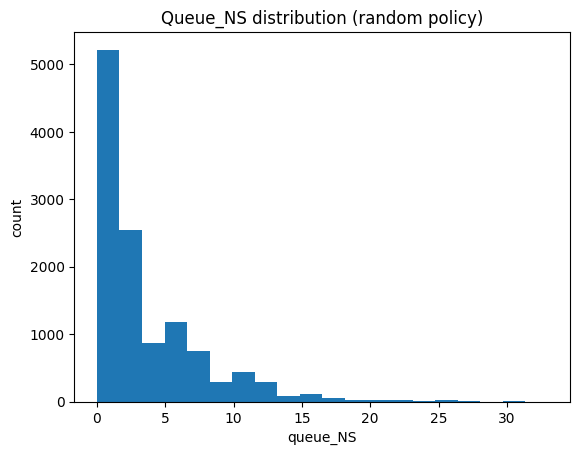

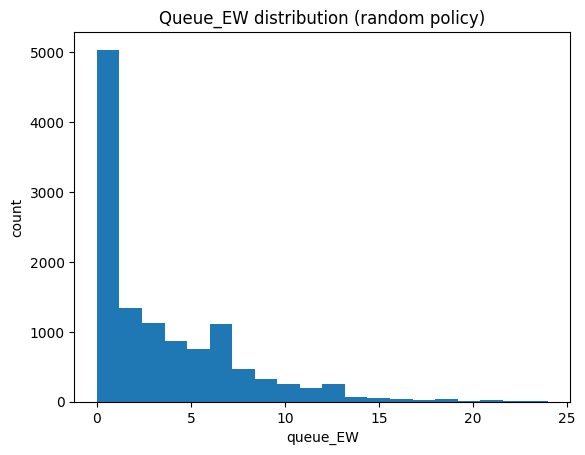

In [5]:
plt.figure()
plt.hist(states[:,0], bins=20)
plt.title("Queue_NS distribution (random policy)")
plt.xlabel("queue_NS"); plt.ylabel("count")
plt.show()

plt.figure()
plt.hist(states[:,1], bins=20)
plt.title("Queue_EW distribution (random policy)")
plt.xlabel("queue_EW"); plt.ylabel("count")
plt.show()


# 4. Data cleaning / validation (important in capstone report)

In [6]:
MAX_Q = env.max_queue

def clean_and_normalize_state(s):
    """
    Data cleaning + normalization:
    - replace invalid values
    - clip queues to [0, MAX_Q]
    - normalize queues to [0,1]
    - keep phase as 0/1
    """
    s = np.array(s, dtype=np.float32)

    # Replace NaN/inf (defensive)
    s = np.nan_to_num(s, nan=0.0, posinf=MAX_Q, neginf=0.0)

    # Clip queues
    s[0] = np.clip(s[0], 0, MAX_Q)
    s[1] = np.clip(s[1], 0, MAX_Q)

    # Phase should be 0 or 1
    s[2] = 1.0 if s[2] >= 0.5 else 0.0

    # Normalize queue lengths to [0,1]
    s[0] = s[0] / MAX_Q
    s[1] = s[1] / MAX_Q
    return s

# Test cleaning
test_s = [999, -5, 3]  # intentionally bad
print("Before:", test_s)
print("After :", clean_and_normalize_state(test_s))


Before: [999, -5, 3]
After : [1. 0. 1.]


In [7]:
class ReplayBuffer:
    def __init__(self, capacity=50000):
        self.buffer = deque(maxlen=capacity)

    def add(self, s, a, r, s2, done):
        self.buffer.append((s, a, r, s2, done))

    def sample(self, batch_size=64):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, s2, done = map(np.array, zip(*batch))
        return s.astype(np.float32), a.astype(np.int32), r.astype(np.float32), s2.astype(np.float32), done.astype(np.float32)

    def __len__(self):
        return len(self.buffer)

def build_q_network(input_dim=3, num_actions=2):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(num_actions)  # Q-values (no softmax)
    ])
    return model


In [8]:
def select_action(q_net, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(0, 2)
    q = q_net(state[None, :], training=False).numpy()[0]
    return int(np.argmax(q))

@tf.function
def train_step(q_net, target_net, optimizer, s, a, r, s2, done, gamma=0.99):
    """
    Standard DQN target:
    y = r + gamma * (1-done) * max_a' Q_target(s2, a')
    Loss = MSE(Q(s,a), y)
    """
    # Compute target Q values
    q_next = target_net(s2, training=False)                  # [B, A]
    max_q_next = tf.reduce_max(q_next, axis=1)               # [B]
    y = r + gamma * (1.0 - done) * max_q_next                # [B]

    with tf.GradientTape() as tape:
        q_all = q_net(s, training=True)                      # [B, A]
        # Gather Q(s,a)
        idx = tf.stack([tf.range(tf.shape(a)[0]), a], axis=1) # [B,2]
        q_sa = tf.gather_nd(q_all, idx)                      # [B]
        loss = tf.reduce_mean(tf.square(y - q_sa))

    grads = tape.gradient(loss, q_net.trainable_variables)
    optimizer.apply_gradients(zip(grads, q_net.trainable_variables))
    return loss


In [9]:
env = TrafficLightEnv(max_steps=300, arrival_ns=0.9, arrival_ew=0.9)

q_net = build_q_network()
target_net = build_q_network()
target_net.set_weights(q_net.get_weights())

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
buffer = ReplayBuffer(capacity=50000)

episodes = 200
batch_size = 64
gamma = 0.99
target_update_every = 10

epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.995

reward_history = []
avg_queue_history = []
loss_history = []

# Warm-up buffer with random actions
s = env.reset()
for _ in range(2000):
    s_clean = clean_and_normalize_state(s)
    a = np.random.randint(0,2)
    s2, r, done, info = env.step(a)
    s2_clean = clean_and_normalize_state(s2)
    buffer.add(s_clean, a, r, s2_clean, done)
    s = s2
    if done:
        s = env.reset()

for ep in range(episodes):
    s = env.reset()
    done = False
    ep_reward = 0
    ep_queues = []

    while not done:
        s_clean = clean_and_normalize_state(s)
        a = select_action(q_net, s_clean, epsilon)
        s2, r, done, info = env.step(a)
        s2_clean = clean_and_normalize_state(s2)

        buffer.add(s_clean, a, r, s2_clean, done)
        ep_reward += r
        ep_queues.append(info["total_wait"] / env.t)  # avg wait proxy so far

        s = s2

        # Train if we have enough samples
        if len(buffer) >= batch_size:
            bs, ba, br, bs2, bdone = buffer.sample(batch_size)
            loss = train_step(q_net, target_net, optimizer, bs, ba, br, bs2, bdone, gamma)
            loss_history.append(float(loss.numpy()))

    reward_history.append(ep_reward)
    avg_queue_history.append(ep_queues[-1])

    # Epsilon decay
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Update target net periodically
    if (ep + 1) % target_update_every == 0:
        target_net.set_weights(q_net.get_weights())

    if (ep + 1) % 20 == 0:
        print(f"Episode {ep+1}/{episodes} | Reward={ep_reward:.1f} | Eps={epsilon:.3f} | AvgWaitProxy={avg_queue_history[-1]:.2f}")


Episode 20/200 | Reward=-2703.0 | Eps=0.905 | AvgWaitProxy=8.16
Episode 40/200 | Reward=-2309.0 | Eps=0.818 | AvgWaitProxy=6.74
Episode 60/200 | Reward=-2412.0 | Eps=0.740 | AvgWaitProxy=7.04
Episode 80/200 | Reward=-2923.0 | Eps=0.670 | AvgWaitProxy=8.74
Episode 100/200 | Reward=-2347.0 | Eps=0.606 | AvgWaitProxy=6.94
Episode 120/200 | Reward=-1771.0 | Eps=0.548 | AvgWaitProxy=4.96
Episode 140/200 | Reward=-1907.0 | Eps=0.496 | AvgWaitProxy=5.29
Episode 160/200 | Reward=-1291.0 | Eps=0.448 | AvgWaitProxy=3.33
Episode 180/200 | Reward=-1423.0 | Eps=0.406 | AvgWaitProxy=3.76
Episode 200/200 | Reward=-1851.0 | Eps=0.367 | AvgWaitProxy=5.16


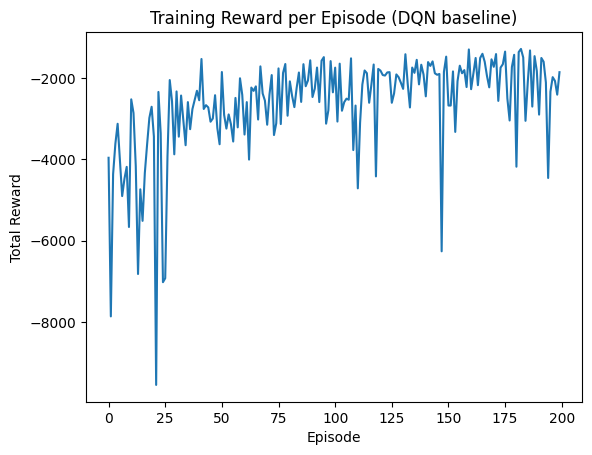

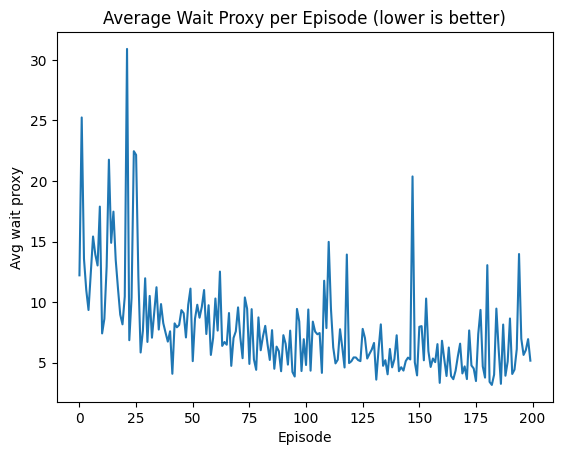

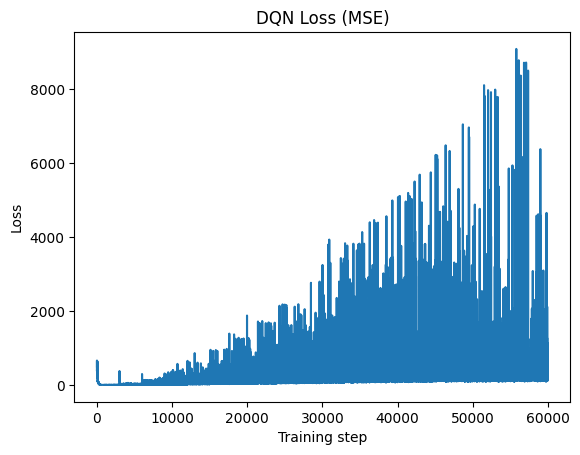

In [10]:
plt.figure()
plt.plot(reward_history)
plt.title("Training Reward per Episode (DQN baseline)")
plt.xlabel("Episode"); plt.ylabel("Total Reward")
plt.show()

plt.figure()
plt.plot(avg_queue_history)
plt.title("Average Wait Proxy per Episode (lower is better)")
plt.xlabel("Episode"); plt.ylabel("Avg wait proxy")
plt.show()

plt.figure()
plt.plot(loss_history)
plt.title("DQN Loss (MSE)")
plt.xlabel("Training step"); plt.ylabel("Loss")
plt.show()


In [15]:
q_net = build_q_network()
target_net = build_q_network()
target_net.set_weights(q_net.get_weights())

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)



# Force optimizer to create its internal variables ONCE
optimizer.build(q_net.trainable_variables)


more_episodes = 120
fine_reward_history = []

for ep in range(more_episodes):
    s = env.reset()
# Force optimizer to create its internal variables ONCE
optimizer.build(q_net.trainable_variables)


more_episodes = 120
fine_reward_history = []

for ep in range(more_episodes):
    s = env.reset()
    done = False
    ep_reward = 0

    while not done:
        s_clean = clean_and_normalize_state(s)
        a = select_action(q_net, s_clean, epsilon)  # keep epsilon low now
        s2, r, done, info = env.step(a)
        s2_clean = clean_and_normalize_state(s2)

        buffer.add(s_clean, a, r, s2_clean, done)
        ep_reward += r
        s = s2

        if len(buffer) >= 64:
            bs, ba, br, bs2, bdone = buffer.sample(64)
            _ = train_step(q_net, target_net, optimizer, bs, ba, br, bs2, bdone, gamma)

    fine_reward_history.append(ep_reward)

    # Even lower exploration
    epsilon = max(0.02, epsilon * 0.999)

    if (ep + 1) % 10 == 0:
        target_net.set_weights(q_net.get_weights())

print("Fine-tuning done ✅")


Fine-tuning done ✅


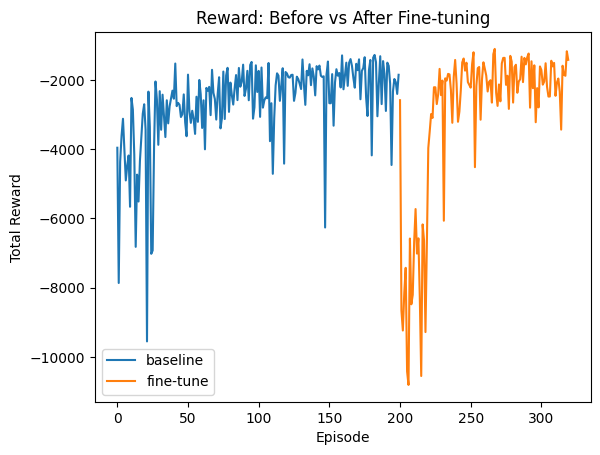

In [16]:
plt.figure()
plt.plot(reward_history, label="baseline")
plt.plot(range(len(reward_history), len(reward_history)+len(fine_reward_history)),
         fine_reward_history, label="fine-tune")
plt.title("Reward: Before vs After Fine-tuning")
plt.xlabel("Episode"); plt.ylabel("Total Reward")
plt.legend()
plt.show()


Fixed-time AvgWaitProxy: 11.67 ± 2.61
RL Policy  AvgWaitProxy: 4.78 ± 1.82


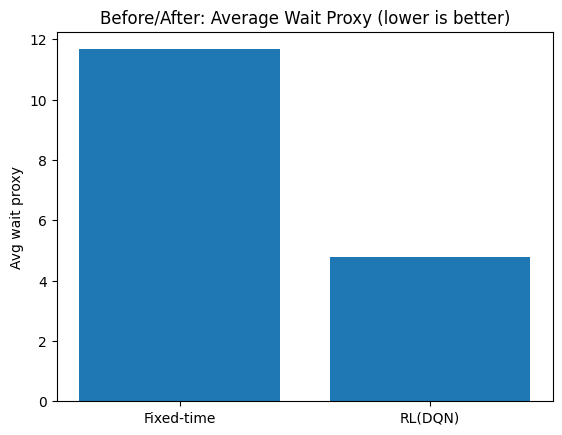

In [17]:
def run_fixed_time(env, K=10, episodes=30):
    waits = []
    for _ in range(episodes):
        s = env.reset()
        done = False
        step = 0
        while not done:
            # switch every K steps
            action = 1 if (step % K == 0 and step > 0) else 0
            s, r, done, info = env.step(action)
            step += 1
        waits.append(info["total_wait"] / env.max_steps)
    return np.mean(waits), np.std(waits)

def run_rl_policy(env, q_net, episodes=30):
    waits = []
    for _ in range(episodes):
        s = env.reset()
        done = False
        while not done:
            s_clean = clean_and_normalize_state(s)
            # greedy action (no exploration)
            q = q_net(s_clean[None,:], training=False).numpy()[0]
            a = int(np.argmax(q))
            s, r, done, info = env.step(a)
        waits.append(info["total_wait"] / env.max_steps)
    return np.mean(waits), np.std(waits)

test_env = TrafficLightEnv(max_steps=300, arrival_ns=0.9, arrival_ew=0.9)

fixed_mean, fixed_std = run_fixed_time(test_env, K=10, episodes=40)
rl_mean, rl_std = run_rl_policy(test_env, q_net, episodes=40)

print(f"Fixed-time AvgWaitProxy: {fixed_mean:.2f} ± {fixed_std:.2f}")
print(f"RL Policy  AvgWaitProxy: {rl_mean:.2f} ± {rl_std:.2f}")

plt.figure()
plt.bar(["Fixed-time", "RL(DQN)"], [fixed_mean, rl_mean])
plt.title("Before/After: Average Wait Proxy (lower is better)")
plt.ylabel("Avg wait proxy")
plt.show()


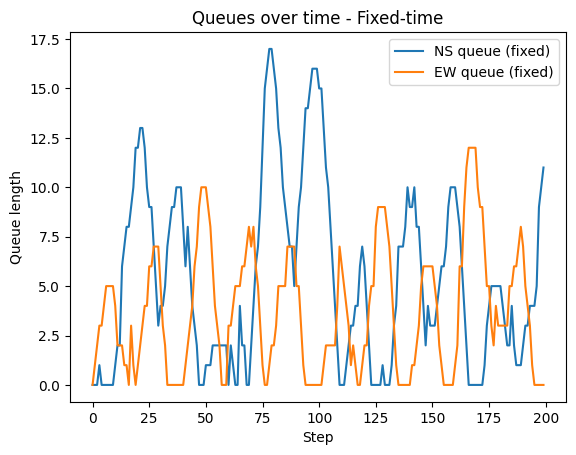

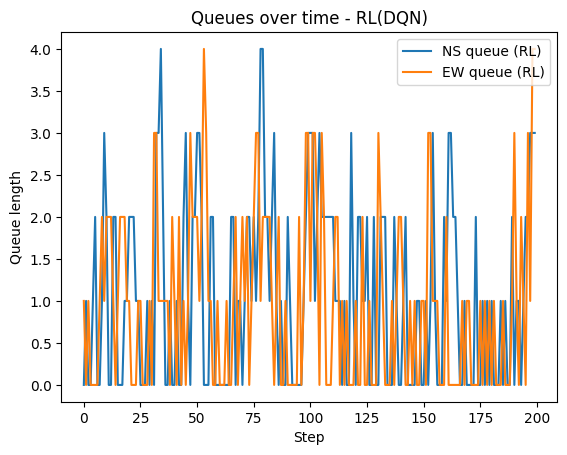

In [18]:
def rollout(env, policy="fixed", K=10, q_net=None):
    s = env.reset()
    done = False
    t = []
    qns = []
    qew = []
    phase = []

    step = 0
    while not done:
        if policy == "fixed":
            action = 1 if (step % K == 0 and step > 0) else 0
        else:
            sc = clean_and_normalize_state(s)
            q = q_net(sc[None,:], training=False).numpy()[0]
            action = int(np.argmax(q))

        s, r, done, info = env.step(action)

        t.append(step)
        qns.append(env.queue_ns)
        qew.append(env.queue_ew)
        phase.append(env.phase)
        step += 1

    return np.array(t), np.array(qns), np.array(qew), np.array(phase)

viz_env = TrafficLightEnv(max_steps=200, arrival_ns=0.9, arrival_ew=0.9)

t1, qns1, qew1, ph1 = rollout(viz_env, policy="fixed", K=10)
t2, qns2, qew2, ph2 = rollout(viz_env, policy="rl", q_net=q_net)

plt.figure()
plt.plot(t1, qns1, label="NS queue (fixed)")
plt.plot(t1, qew1, label="EW queue (fixed)")
plt.title("Queues over time - Fixed-time")
plt.xlabel("Step"); plt.ylabel("Queue length")
plt.legend()
plt.show()

plt.figure()
plt.plot(t2, qns2, label="NS queue (RL)")
plt.plot(t2, qew2, label="EW queue (RL)")
plt.title("Queues over time - RL(DQN)")
plt.xlabel("Step"); plt.ylabel("Queue length")
plt.legend()
plt.show()
